In [1]:
import torch
import torch.nn as nn
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers the 3D projection

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
EPOCHS = 7000
LR = 1e-3

# Cantidad de puntos
N_DOM  = 2048  # Collocation points en el interior

In [4]:
class NetU(nn.Module):
    """
    Red neuronal para aproximar u(x,t).
    """
    def __init__(self, layers=[2,64,64,64,1], activation=nn.Tanh()):
        super(NetU, self).__init__()
        self.net = nn.Sequential()
        for i in range(len(layers)-1):
            self.net.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                self.net.append(activation)

    def forward(self, x, t):
        # concatenamos x y t como (N,2)
        inp = torch.cat((x,t), dim=1)
        return self.net(inp)

In [5]:
# Construimos redes
torch.manual_seed(42)
net_u = NetU([2,64,64,64,1]).to(device)

In [6]:
def sample_domain(n):
    x = torch.rand(n,1, device=device, requires_grad=True)
    t = torch.rand(n,1, device=device, requires_grad=True)
    return x, t

In [7]:
def objective_function(x,t):
    return x*(x - 0.5)*(1 - x)*(1 + 2*t)

In [8]:
def loss_fn(x,t):
    nn = net_u(x,t)
    data = objective_function(x,t)
    loss = torch.mean((nn - data)**2)
    return loss

In [9]:
optimizer_u = torch.optim.Adam(net_u.parameters(), lr=LR)

# Para graficar más adelante
loss_history          = []

for epoch in range(EPOCHS):
    optimizer_u.zero_grad()
    x, t = sample_domain(N_DOM)
    total_loss = loss_fn(x,t)
    total_loss.backward()

    optimizer_u.step()

    # Guardamos las pérdidas
    loss_history.append(total_loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch:5d} | Loss: {total_loss.item():.3e}")

Epoch     0 | Loss: 5.400e-02
Epoch   500 | Loss: 8.128e-04
Epoch  1000 | Loss: 9.523e-05
Epoch  1500 | Loss: 4.543e-05
Epoch  2000 | Loss: 2.226e-05
Epoch  2500 | Loss: 1.887e-05
Epoch  3000 | Loss: 1.337e-05
Epoch  3500 | Loss: 9.054e-06
Epoch  4000 | Loss: 7.013e-06
Epoch  4500 | Loss: 1.742e-05
Epoch  5000 | Loss: 2.392e-05
Epoch  5500 | Loss: 9.558e-06
Epoch  6000 | Loss: 5.615e-06
Epoch  6500 | Loss: 3.299e-05


**Potting the NN**

In [10]:
# 1) build a uniform grid in x,t
n_pts = 100  # resolution along each axis
x = np.linspace(0, 1, n_pts)
t = np.linspace(0, 1, n_pts)
X, T = np.meshgrid(x, t)

# 2) flatten and convert to torch tensors
X_flat = torch.from_numpy(X.reshape(-1, 1)).float()
T_flat = torch.from_numpy(T.reshape(-1, 1)).float()

# 3) evaluate the network in batch (no grad needed)
with torch.no_grad():
    U_flat = net_u(X_flat.to(device), T_flat.to(device))

# 4) reshape back to grid
U = U_flat.cpu().numpy().reshape(n_pts, n_pts)

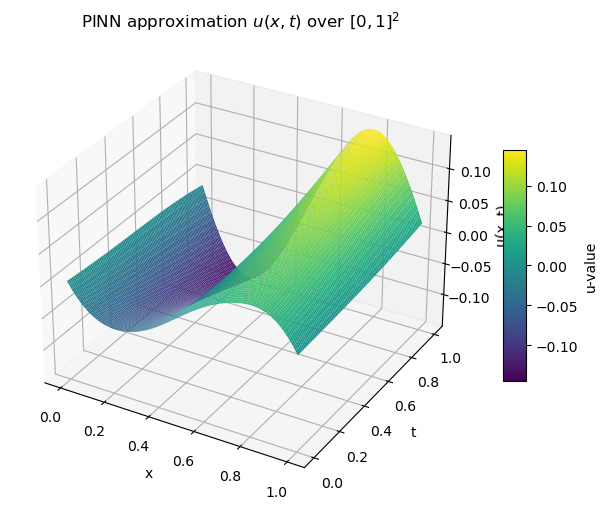

In [11]:
# 5) plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# surface plot; cmap optional
surf = ax.plot_surface(X, T, U, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x, t)')
ax.set_title('PINN approximation $u(x,t)$ over $[0,1]^2$')

fig.colorbar(surf, shrink=0.5, aspect=10, label='u-value')
plt.show()    

**Saving the the NN on the grid points (txt file)**

In [12]:
# --- 1) Parameters & grid definitions ---
h  = 0.1      # Δx
dt = 0.05     # Δt
x_vals = torch.arange(0, 1 + h,  h).float()   
t_vals = torch.arange(0, 1 + dt, dt).float() 

# create an (Nx, Nt) meshgrid with indexing='ij' so that
#   X[i,j] = x_vals[i],  T[i,j] = t_vals[j]
X, T = torch.meshgrid(x_vals, t_vals, indexing='ij')  

# --- 2) Evaluate the network over the whole grid ---
net_u.eval()
with torch.no_grad():
    # flatten both to (Nx*Nt, 1) for batch eval
    Xf = X.reshape(-1, 1)
    Tf = T.reshape(-1, 1)
    Uf = net_u(Xf.to(device), Tf.to(device))               # (Nx*Nt, 1)
    U  = Uf.reshape(X.shape)        # back to (Nx, Nt)

# --- 3) Convert to NumPy and save ---
U_np = U.cpu().numpy()               # shape (Nx, Nt)
np.savetxt('u_grid.txt', U_np, fmt='%.6e', delimiter=' ')

print("Saved u(x_i, t_j) on a (Nx × Nt) grid to 'u_grid.txt'")

Saved u(x_i, t_j) on a (Nx × Nt) grid to 'u_grid.txt'


**Saved values sanity check**

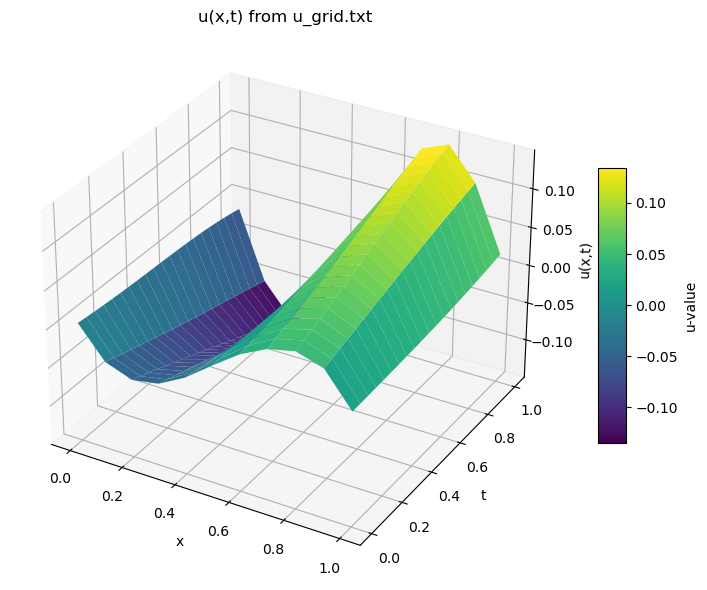

In [13]:
# 1) Load the data
U = np.loadtxt('u_grid.txt', delimiter=' ')  # shape (Nx, Nt)

# 2) Recreate the x and t vectors you used when saving
h  = 0.1
dt = 0.05
x_vals = np.arange(0, 1 + h,  h)   # length Nx
t_vals = np.arange(0, 1 + dt, dt)  # length Nt

# 3) Make a meshgrid (so X[i,j], T[i,j] align with U[i,j])
X, T = np.meshgrid(x_vals, t_vals, indexing='ij')

# --- Option A: 3D surface plot ---
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, T, U, cmap='viridis', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.set_title('u(x,t) from u_grid.txt')
fig.colorbar(surf, shrink=0.5, aspect=10, label='u-value')
plt.tight_layout()
plt.show()